In [2]:
# Import neccesary libraries

import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import cv2

In [3]:
# Training images preprocessing
def preprocess_images(data_dir, img_size):
    x_train = []
    y_train = []

    # Loop through all image folders in training folder
    for folder in os.listdir(data_dir):
        label = folder
        if label == '.DS_Store':
            continue

        folder_path = os.path.join(data_dir, folder)
        # print(folder_path)

        # Loop through all images in each classification folder
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path)

            # If not an image: skip
            if img is None:
                continue

            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Grayscaling images
            x_train.append(img)
            y_train.append(label)

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    return x_train, y_train

In [4]:
# Training images file path
data_dir = './images/training'
data_dir = pathlib.Path(data_dir)

# Number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

# Preprocess training images with specific image size
img_size = 224
x_train, y_train = preprocess_images(data_dir, img_size)

878


In [5]:
# Training images file path
test_data_dir = './images/testing'
test_data_dir = pathlib.Path(test_data_dir)

# Number of images
image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(image_count)

# Preprocess training images with specific image size
img_size = 224
x_test, y_test = preprocess_images(test_data_dir, img_size)

167


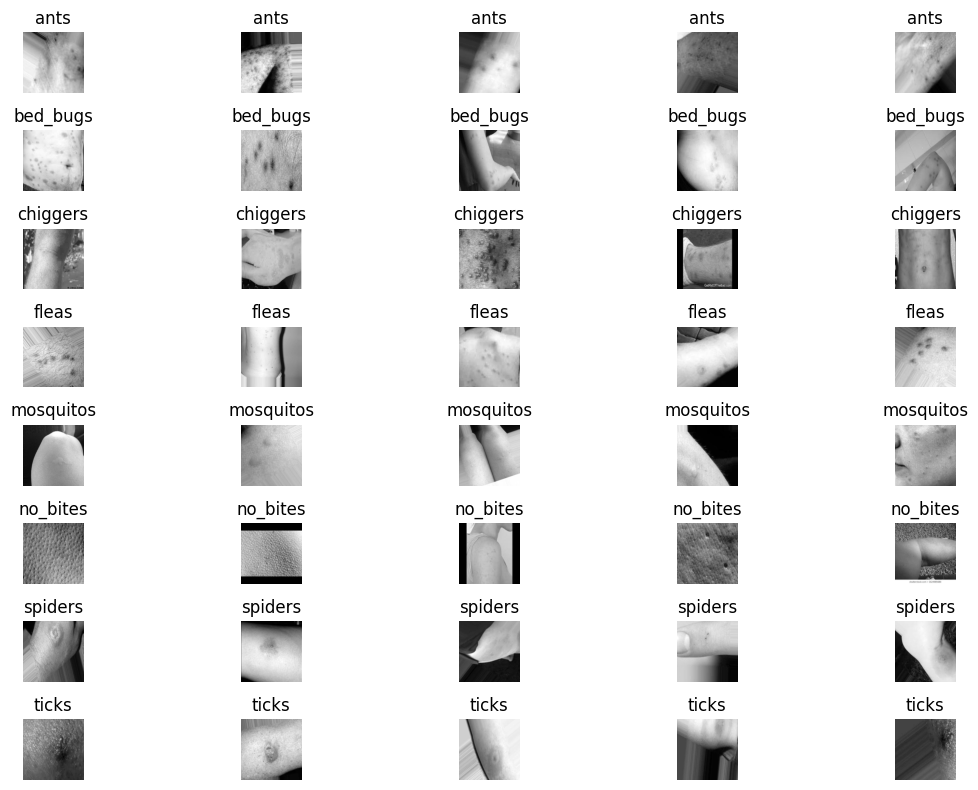

In [4]:
# Define a function to display sample images
def display_sample_images(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == class_name)[0]
        sample_indices = np.random.choice(
            class_indices, num_samples, replace=False)
        for j, idx in enumerate(sample_indices):
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


# Display sample images
class_names = np.unique(y_train)
display_sample_images(x_train, y_train, class_names)

In [7]:
import os
import cv2
import numpy as np

# Function to fetch images and labels from directory


def fetch_images_and_labels(data_dir):
    images = []
    labels = []

    # Loop through each subdirectory (bug bite type)
    for label in os.listdir(data_dir):
        if label == '.DS_Store':  # Skip macOS system files
            continue
        label_dir = os.path.join(data_dir, label)

        # Loop through each image in the subdirectory
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            # Read the image and convert to grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                # Resize the image to a fixed size (e.g., 224x224)
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(label)

    return np.array(images), np.array(labels)


# Define the image directory
data_dir = './images/training'

# Fetch images and labels
images, labels = fetch_images_and_labels(data_dir)

# Display the shape of the fetched images and labels
print("Number of images:", len(images))
print("Number of labels:", len(labels))
print("Unique labels:", np.unique(labels))

Number of images: 1564
Number of labels: 1564
Unique labels: ['ants' 'bed_bugs' 'chiggers' 'fleas' 'mosquitos' 'no_bites' 'spiders'
 'ticks']


In [8]:
test_images, test_labels = fetch_images_and_labels(test_data_dir)

In [6]:
import tensorflow as tf
from keras import layers, models


def r_cnn_model(input_shape, num_classes):
    # Input layer
    input_tensor = layers.Input(shape=input_shape)

    # Repeat grayscale channel to match RGB channels expected by VGG16
    input_tensor_rgb = layers.Concatenate(axis=-1)([input_tensor]*3)

    # Region Proposal Network (RPN)
    def rpn_network(base_features):
        # Convolutional layer with 256 filters, 3x3 kernel size, and ReLU activation
        x = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(base_features)

        # Classification layer with 2 filters (foreground/background), 1x1 kernel size, and sigmoid activation
        # Output shape: (H, W, num_anchors * 2), where num_anchors is the number of anchor boxes per pixel
        cls_output = layers.Conv2D(
            2, (1, 1), activation='sigmoid', name='rpn_cls')(x)

        # Regression layer with 4 filters (for bounding box coordinates), 1x1 kernel size
        # Output shape: (H, W, num_anchors * 4), where num_anchors is the number of anchor boxes per pixel
        reg_output = layers.Conv2D(
            4, (1, 1), activation='linear', name='rpn_reg')(x)

        return cls_output, reg_output

    # Define input tensor for the RPN
    base_model = tf.keras.applications.VGG16(
        weights='imagenet', include_top=False, input_tensor=input_tensor_rgb)
    # Use a layer from the VGG16 model as input
    rpn_input_tensor = base_model.get_layer('block4_conv3').output

    # Create the RPN model
    rpn_cls_output, rpn_reg_output = rpn_network(rpn_input_tensor)

    # Feature Extraction (CNN)
    for layer in base_model.layers:
        layer.trainable = False

    # Classification Head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    predictions_cls = layers.Dense(
        num_classes, activation='softmax', name='predictions_cls')(x)

    # Bounding Box Regression Head
    predictions_reg = layers.Dense(
        num_classes * 4, activation='linear', name='predictions_reg')(x)

    # Create the R-CNN model
    model = models.Model(inputs=input_tensor, outputs=[
                         predictions_cls, predictions_reg, rpn_cls_output, rpn_reg_output])

    return model


# Define input shape and number of classes
input_shape = (224, 224, 1)  # Update input shape based on your images
num_classes = 8  # Update number of bug bite classes

# Create the R-CNN model
model = r_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss={
              'predictions_cls': 'categorical_crossentropy', 'predictions_reg': 'mse'})

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 3)                │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ concatenate[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 28,762,222 (109.72 MB)

 Trainable params: 14,047,534 (53.59 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
from tensorflow import keras
from keras import optimizers, losses, metrics

# Compile the R-CNN model


def compile_r_cnn_model(model):
    # Optimizer
    # Adjust the learning rate as needed
    optimizer = optimizers.Adam(learning_rate=1e-4)

    # Loss functions
    # Use categorical cross-entropy for classification and mean squared error (MSE) for regression
    loss = {
        'predictions_cls': 'categorical_crossentropy',  # Classification loss
        'predictions_reg': 'mse',  # Regression loss for bounding box coordinates
        'rpn_cls': 'categorical_crossentropy',  # RPN classification loss
        'rpn_reg': 'mse'  # RPN regression loss
    }

    # Metrics to monitor during training
    metrics_list = {
        'predictions_cls': ['accuracy'],  # Classification accuracy
        'predictions_reg': [],  # No specific metric for bounding box regression
        'rpn_cls': ['accuracy'],  # RPN classification accuracy
        'rpn_reg': []  # No specific metric for RPN bounding box regression
    }

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics_list)

    return model

In [8]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ensure Eager execution is enabled
# Enable Eager mode to avoid graph-related errors
tf.config.run_functions_eagerly(True)

# Define training parameters
batch_size = 24  # Number of samples per training batch
epochs = 10  # Number of times the model will iterate over the dataset

# Data augmentation for training
data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Rotate images by a random angle within this range
    width_shift_range=0.2,  # Shift images horizontally by a fraction of total width
    height_shift_range=0.2,  # Shift images vertically by a fraction of total height
    shear_range=0.2,  # Shear images by a random angle
    zoom_range=0.2,  # Zoom into images by a random factor
    horizontal_flip=True  # Randomly flip images horizontally
)

# Data augmentation for validation (usually fewer transformations)
val_data_augmentation = ImageDataGenerator(rescale=1.0 / 255.0)

# Create separate data generators for training and validation
train_generator = data_augmentation.flow_from_directory(
    data_dir,  # Update with the path to your training images folder
    target_size=(224, 224),  # Consistent image size
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    shuffle=True,  # Shuffle data for randomness
    color_mode='rgb'  # Ensure the output is in RGB format
)

validation_generator = val_data_augmentation.flow_from_directory(
    './images/validation',  # Update with the path to your validation images folder
    target_size=(224, 224),  # Consistent image size
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    shuffle=False,  # No shuffle for validation data
    color_mode='rgb'  # Ensure the output is in RGB format
)

# Define the R-CNN model with the appropriate input shape
input_shape = (224, 224, 3)  # RGB images with three color channels

# Define the R-CNN model function


def r_cnn_model(input_shape, num_classes):
    # Input tensor for the model
    input_tensor = keras.Input(shape=input_shape, name='input_tensor')

    # Feature extraction using a pre-trained VGG16 model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Region Proposal Network (RPN)
    def rpn_network(input_tensor):
        # Convolutional layers for RPN
        x = layers.Conv2D(512, (3, 3), padding='same',
                          activation='relu')(input_tensor)

        # RPN classification output (object/no object)
        cls_output = layers.Conv2D(
            2, (1, 1), activation='softmax', name='rpn_cls')(x)

        # RPN regression output (bounding box coordinates)
        reg_output = layers.Conv2D(
            4, (1, 1), activation='linear', name='rpn_reg')(x)

        return cls_output, reg_output

    # Create the RPN
    rpn_cls_output, rpn_reg_output = rpn_network(
        base_model.get_layer('block4_conv3').output)

    # Classification head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)  # Fully connected layer
    predictions_cls = layers.Dense(
        num_classes, activation='softmax', name='predictions_cls')(x)

    # Bounding box regression head
    predictions_reg = layers.Dense(
        # Coordinates
        num_classes * 4, activation='linear', name='predictions_reg')(x)

    # Create the complete R-CNN model with input tensor and outputs
    model = models.Model(inputs=input_tensor, outputs=[
                         predictions_cls, predictions_reg, rpn_cls_output, rpn_reg_output])

    return model


# Create the R-CNN model with the defined input shape and number of classes
model = r_cnn_model(input_shape, 8)  # 8 classes, update based on your dataset

# Compile the model with the appropriate optimizer and loss functions
model.compile(
    # You can adjust the learning rate
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss={
        'predictions_cls': 'categorical_crossentropy',  # Classification loss
        'predictions_reg': 'mse',  # Regression loss for bounding box prediction
        'rpn_cls': 'categorical_crossentropy',  # RPN classification loss
        'rpn_reg': 'mse'  # RPN regression loss
    },
    metrics={
        'predictions_cls': ['accuracy'],  # Monitor accuracy
        'rpn_cls': ['accuracy']  # Monitor RPN accuracy
    }
)

# Callbacks for training (early stopping and model checkpoint)
callbacks = [
    # Stop training if validation loss doesn't improve
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)  # Save the best model
]

# Train the model with separate training and validation data generators
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks  # Implement early stopping and model checkpoint
)

# Return the training history for analysis
history

Found 1564 images belonging to 8 classes.
Found 186 images belonging to 8 classes.
Epoch 1/30


C:\Users\triti\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\triti\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\triti\AppData\Roaming\Python\Python310\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] w

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 2.1376 - predictions_cls_accuracy: 0.1785 
Epoch 1: val_loss improved from inf to 1.99009, saving model to best_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 743s 11s/step - loss: 2.1362 - predictions_cls_accuracy: 0.1788 - val_loss: 1.9901 - val_predictions_cls_accuracy: 0.1720
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 1.8537 - predictions_cls_accuracy: 0.2859 
Epoch 2: val_loss improved from 1.99009 to 1.88670, saving model to best_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 746s 11s/step - loss: 1.8532 - predictions_cls_accuracy: 0.2863 - val_loss: 1.8867 - val_predictions_cls_accuracy: 0.2204
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 1.6169 - predictions_cls_accuracy: 0.4419 
Epoch 3: val_loss improved from 1.88670 to 1.82750, saving model to best_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 758s 11s/step - loss: 1.6162 - predictions_cls_accuracy: 0.4417 - val_loss: 1.8275 - val_predictions_cls_accuracy: 0.3172
Epoch 4/30

In [9]:
test_model = tf.keras.models.load_model('best_model.keras')

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator for test dataset
test_data_generator = ImageDataGenerator(rescale=1.0 / 255.0)

# Load test data from a directory
test_generator = test_data_generator.flow_from_directory(
    './images/testing',  # Update with your test dataset directory
    target_size=(224, 224),  # Ensure consistent image size
    batch_size=24,  # Adjust batch size based on your test dataset size
    class_mode='categorical',  # Specify the type of classification
    shuffle=False  # Keep test data in order for consistent results
)

Found 177 images belonging to 8 classes.


In [15]:
import tensorflow as tf

# Enable Eager execution
tf.config.run_functions_eagerly(True)

# Try evaluating the model again
test_loss, test_accuracy = test_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

tf.config.run_functions_eagerly(False)

C:\Users\triti\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.8946 - predictions_cls_accuracy: 0.6030
Test Loss: 0.8549716472625732
Test Accuracy: 0.6440678238868713


In [12]:
# Make predictions on the test dataset
predictions = test_model.predict(test_generator)

# Display or analyze predictions
print("Predictions:", predictions)

C:\Users\triti\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Predictions: [array([[5.7909049e-02, 7.9471329e-03, 8.1326865e-02, ..., 1.2985596e-01,
        8.1306258e-03, 1.5098330e-01],
       [9.9355197e-01, 1.1308757e-04, 6.0876189e-03, ..., 6.2722916e-05,
        4.6953064e-05, 7.6349870e-06],
       [3.0636084e-01, 2.5928689e-02, 2.7136695e-01, ..., 7.8461344e-05,
        1.0008932e-04, 1.4659384e-03],
       ...,
       [1.8099628e-01, 4.4955974e-05, 1.4452399e-03, ..., 1.2146102e-04,
        2.7279806e-01, 5.4333067e-01],
       [2.8257720e-05, 3.7538463e-03, 2.5696659e-02, ..., 6.3592517e-03,
        1.8961735e-02, 9.0010524e-01],
       [4.5912500e-05, 1.1653184e-02, 3.5565790e-02, ..., 2.3201462e-04,
        6.6763267e-04, 9.1940206e-01]], dtype=float32), array([[ 1.8944194 , -0.13436112,  2.310978  , ...,  1.8160055 ,
         1.6763458 ,  2.2231045 ],
       [ 0.88027495, -1.5699159 ,  2.0306764 , ...,  0.37394944,
         1.8966842 ,  1.804501  ],
       [ 0.60037744, -1.6724346 ,  3.3252435 , .

In [18]:
import numpy as np

# Assuming 'predictions[0]' contains the probability arrays
probabilities = predictions[0]
predicted_class_indices = np.argmax(probabilities, axis=1)

# If you have class labels as a list
predicted_labels = [labels[idx] for idx in predicted_class_indices]

print("Predicted class labels:", predicted_labels)

Predicted class labels: ['ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants',

In [19]:
# Assuming 'predictions[1]' contains the bounding box or other regression outputs
bounding_boxes = predictions[1]
print("Predicted bounding boxes or regression outputs:", bounding_boxes)

Predicted bounding boxes or regression outputs: [[ 1.8944194  -0.13436112  2.310978   ...  1.8160055   1.6763458
   2.2231045 ]
 [ 0.88027495 -1.5699159   2.0306764  ...  0.37394944  1.8966842
   1.804501  ]
 [ 0.60037744 -1.6724346   3.3252435  ... -0.13205886  2.1787834
   2.8008115 ]
 ...
 [ 1.6708256  -2.3556266   2.2016697  ...  0.19609863  2.7365727
   0.31146216]
 [ 1.280308   -1.7826157   2.112531   ... -0.12948936  0.7964884
   1.1932347 ]
 [ 1.476048   -1.3457825   2.670798   ... -0.31905767  1.2865298
   2.171408  ]]


In [20]:
from sklearn.metrics import accuracy_score

true_labels = test_generator.classes  # True class indices
print("Accuracy:", accuracy_score(true_labels, predicted_class_indices))

Accuracy: 0.6440677966101694


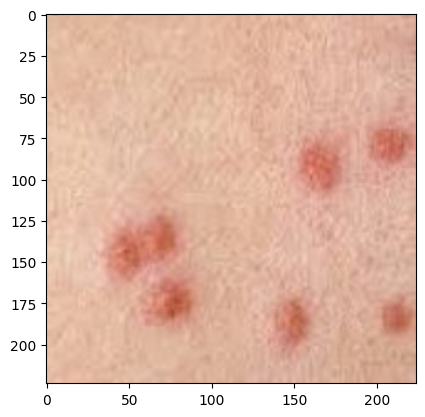

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


def visualize_predictions(image_path, bounding_box, target_size=(224, 224)):
    """ Visualize bounding box on the image, resizing the image to target size. """
    # Load and resize image
    img = Image.open(image_path)
    # Resize to the size used in training
    img = img.resize(target_size)

    # Convert to array for plotting
    img = np.array(img)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Assuming bounding box is [x_min, y_min, width, height]
    # Scale bounding box coordinates to resized image dimensions
    scale_x = target_size[0] / 150
    scale_y = target_size[1] / 150
    rect = patches.Rectangle((bounding_box[0]*scale_x, bounding_box[1]*scale_y), bounding_box[2]*scale_x, bounding_box[3]*scale_y,
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()


# Example usage
sample_image_path = './images/testing/ants/antsimage19 (2).jpg'
sample_bounding_box = bounding_boxes[0]  # Assuming the first bounding box
visualize_predictions(sample_image_path, sample_bounding_box)